# Modeling Notebook - Positive/Negative/Neutral Classifier

In [2]:
# Import the required libraries
import nltk
from nltk.corpus import stopwords
from nltk import word_tokenize, FreqDist
from nltk.tokenize import TweetTokenizer
import string
import wordcloud

from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.metrics import accuracy_score, plot_confusion_matrix
from sklearn.ensemble import RandomForestClassifier
from sklearn.naive_bayes import MultinomialNB
from sklearn.svm import LinearSVC
from sklearn.metrics import plot_confusion_matrix, classification_report
from sklearn.model_selection import train_test_split
from sklearn.pipeline import Pipeline 


import pandas as pd
import numpy as np
from PIL import Image
from os import path

import matplotlib.pyplot as plt
import matplotlib.colors
import seaborn as sns

np.random.seed(42)


In [3]:
# Function Definitions 

def plot_pretty_cf(predictor, xtest, ytest, cmap='Blues', normalize='true', title=None):
    fig, ax = plt.subplots(figsize=(8, 8))
    plot_confusion_matrix(predictor, xtest, ytest, cmap=cmap, normalize=normalize, ax=ax)
    ax.set_title(title, size='large')
    ax.set_xlabel('Predicted Label', size='medium')
    ax.set_ylabel('True Label', size='medium')
    plt.show()

def get_eng_stopwords_list():
    # Get English stopwords, punctuation, and 'empty text' signifiers (like empty quotes and ...)
    return stopwords.words('english')  + list(string.punctuation) + ["''", '""', '...', '``']

def get_social_media_stopwords_list():
    return stopwords.words('english') + ['rt', 'link', '&'] + list(string.punctuation) + ["''", '""', '..', '...', '``']

def tokenize_tweet(tweet):
    tweet_tokenizer = TweetTokenizer(preserve_case=False, strip_handles=True, reduce_len=True)
    tokens = tweet_tokenizer.tokenize(tweet)
    #TODO: any stemming you might want to do
    return tokens

def process_tweet_text_encode_to_ascii(tweet, stopwords_list):
    #tokenize, lowercase each token, remove stopwords
    stopwords_removed = ''
    tweet_tokenizer = TweetTokenizer(preserve_case=False, strip_handles=True, reduce_len=True)
    try:
        tweet_encode = tweet.encode("ascii", "ignore")
        tweet_decode = tweet_encode.decode()
        tokens = tweet_tokenizer.tokenize(tweet_decode)
        #print(tokens)
        stopwords_removed = [token for token in tokens if token not in stopwords_list]
    except:
        print('Could not encode/decode ', tweet )
    return stopwords_removed

def plot_word_cloud(text, word_max, stopwords_list, bg_color='black'):
    cloud = wordcloud.WordCloud(background_color=bg_color, 
                            min_word_length=2,
                            max_words=word_max)
    cloud.generate(text)
    
    # plot it
    plt.figure(figsize=(15,10))
    plt.imshow(cloud, interpolation='bilinear') 
    plt.axis("off")
    plt.show()

#TODO: figure out why this is not working to apply the image as mask
def plot_word_cloud_with_mask(text, word_max, stopwords_list, bg_color='black'):
    # get data directory (using getcwd() is needed to support running example in generated IPython notebook)
    d = path.dirname(__file__) if "__file__" in locals() else os.getcwd()
    twitter_mask = np.array(Image.open('../images/twitter.png'))
    cloud = wordcloud.WordCloud(background_color=bg_color, 
                            min_word_length=2,
                            mask=twitter_mask,
                            contour_width=3, 
                            contour_color='steelblue',
                            max_words=word_max)
    cloud.generate(text)
    # store to file
    cloud.to_file(path.join(d, "twitter_cloud.png"))
    # plot it
    #plt.figure(figsize=(15,10))
    plt.imshow(cloud, interpolation='bilinear') 
    plt.axis("off")
    plt.imshow(twitter_mask, cmap=plt.cm.gray, interpolation='bilinear')
    plt.axis("off")
    plt.show()



In [4]:
# read in the processed data
pos_tweets = pd.read_csv('../data/cleaned_tweets_positive.csv', encoding='unicode_escape')
print(pos_tweets.shape)

neg_tweets = pd.read_csv('../data/cleaned_tweets_negative.csv', encoding='unicode_escape')
print(neg_tweets.shape)

neutral_tweets = pd.read_csv('../data/cleaned_tweets_neutral.csv', encoding='unicode_escape')
print(neutral_tweets.shape)

all_tweets = pd.read_csv('../data/cleaned_tweets_all.csv')
print(all_tweets.shape)


(2861, 7)
(544, 7)
(5293, 7)
(8698, 7)


## Corpus Exploration
* What are the most common words found in Positive, Negative and Neutral Tweets?

In [5]:
# Create word clouds of the most common words in Positive, Negative (and Neutral) Tweets

positive_tweet_words = list()
for tweet in pos_tweets['tweet_text'].to_list():
    processed_tweet = process_tweet_text_encode_to_ascii(tweet, get_social_media_stopwords_list())
    for word in processed_tweet:
        positive_tweet_words.append(word)

negative_tweet_words = list()
for tweet in neg_tweets['tweet_text'].to_list():
    processed_tweet = process_tweet_text_encode_to_ascii(tweet, get_social_media_stopwords_list())
    for word in processed_tweet:
        negative_tweet_words.append(word)

neutral_tweet_words = list()
for tweet in neutral_tweets['tweet_text'].to_list():
    processed_tweet = process_tweet_text_encode_to_ascii(tweet, get_social_media_stopwords_list())
    for word in processed_tweet:
        neutral_tweet_words.append(word)


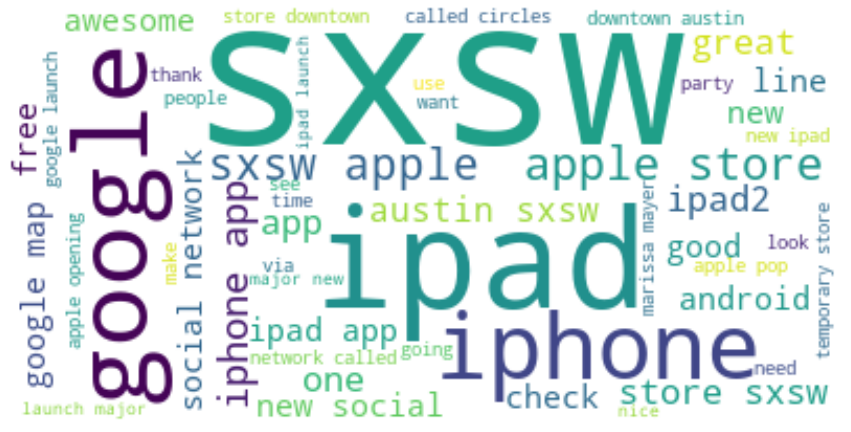

In [6]:
# Postive Tweets top 50 words
positive_text = ' '.join(word for word in positive_tweet_words)
plot_word_cloud(positive_text, 50, get_social_media_stopwords_list(), 'white')

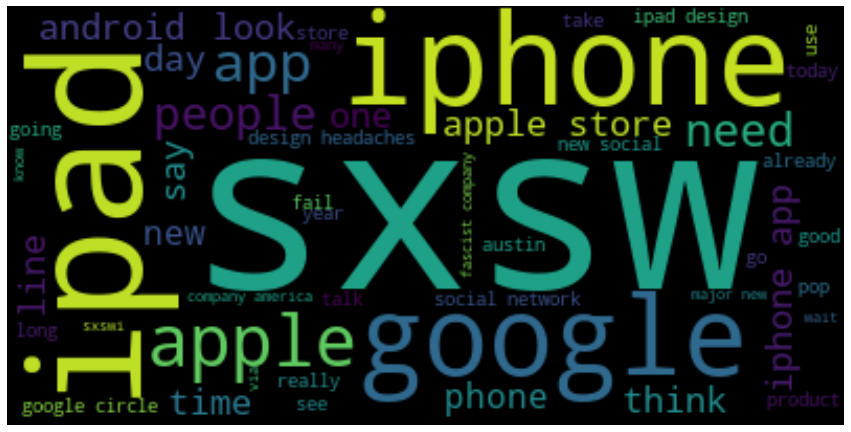

In [7]:
# Negative Tweets top 50 words
negative_text = ' '.join(word for word in negative_tweet_words)
plot_word_cloud(negative_text, 50, get_social_media_stopwords_list())

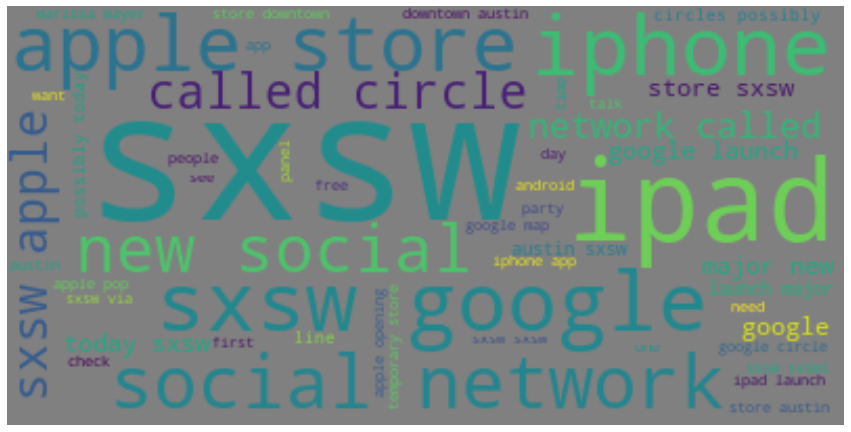

In [8]:
# Neutral Tweets top 50 words
neutral_text = ' '.join(word for word in neutral_tweet_words)
plot_word_cloud(neutral_text, 50, get_social_media_stopwords_list(), 'grey')

## Text Processing for Classification Model

In [9]:
##
# - Create TRAIN and TEST data sets from the Postive and Negative Tweet datasets.
# - Separate the data (tweet_text) and the labels (sentiment) in both TRAIN and TEST
# - Process the TRAIN tweets
# - Explore TRAIN data with Freq Dist?
# - Vectorize TRAIN with sklearn
# - Create a basic model (try MultinomialNB and RandomForestClassifier )
# - Fit each to our vectorized training data
# - Create predictions for TRAIN and TEST sets
# - Calculate the accuracy_score() for both TRAIN and TEST 
# - Experiment with model tuning AND/OR other model choices
#
# TODO decide the best peformance measure, accuracy or precision. What makes sense from a business POV?

In [10]:
# Get TRAIN and TEST data and target and prep for processing steps
corpus = all_tweets['tweet_text'].tolist()
labels = all_tweets['sentiment'].tolist()
train_tweets, test_tweets, train_sentiment, test_sentiment = train_test_split(corpus, labels, test_size=0.3, random_state=42)

In [11]:
# Text Processing - TF-IDF
# Use TF_IDF to focus on words that appear heavily in tweets from a given class, but rarely appear in tweets from other class/classes.
# Use tokenzer for tweets and the customized stopwords list

# noticed the #sxsw hastag was in all categories very often, add it to stopwords
custom_stopwords = get_social_media_stopwords_list() + ['#sxsw', 'sxsw', '##sxsw']
vectorizer = TfidfVectorizer(analyzer='word',
                            tokenizer=tokenize_tweet, 
                            stop_words=custom_stopwords,  
                            strip_accents='unicode',
                            decode_error='ignore')

# Fit on TRAIN data
tf_idf_data_train = vectorizer.fit_transform(train_tweets)
# Creat a vectorized version of the TEST data
tf_idf_data_test = vectorizer.transform(test_tweets)

In [12]:
# Model creation
# create some models and fit them to our vectorized training data
nb_classifier = MultinomialNB()
rf_classifier = RandomForestClassifier(n_estimators=100)

In [13]:
# TF-IDF - Let's check out the vocab for the ENTIRE corpus of Pos/Neg/Neutral Tweets...Train and Test
print(len(vectorizer.vocabulary_.keys()))

8576


In [15]:
# Let's see what terms were important
# print idf values 
df_idf = pd.DataFrame(vectorizer.idf_, index=vectorizer.get_feature_names(),columns=["idf_weights"]) 
 
df_idf.sort_values(by=['idf_weights'], ascending=False)[:50]

,idf_weights
##apple_store,9.021092
insidious,9.021092
integrates,9.021092
instrumental,9.021092
instructions,9.021092
instore,9.021092
installs,9.021092
inspired,9.021092
inspiration,9.021092
insists,9.021092


In [370]:
nb_classifier.fit(tf_idf_data_train, train_sentiment)
nb_train_preds = nb_classifier.predict(tf_idf_data_train)
nb_test_preds = nb_classifier.predict(tf_idf_data_test)

In [371]:
nb_train_score = accuracy_score(train_sentiment, nb_train_preds)
nb_test_score = accuracy_score(test_sentiment, nb_test_preds)

print("Multinomial Naive Bayes")
print("Training Accuracy: {:.4} \t\t Testing Accuracy: {:.4}".format(nb_train_score, nb_test_score))

Multinomial Naive Bayes
Training Accuracy: 0.7571 		 Testing Accuracy: 0.6648


In [372]:
print(classification_report(test_sentiment, nb_test_preds, target_names=['Negative', 'Neutral', 'Positive']))

              precision    recall  f1-score   support

    Negative       0.00      0.00      0.00       169
     Neutral       0.66      0.96      0.78      1573
    Positive       0.73      0.26      0.39       868

    accuracy                           0.66      2610
   macro avg       0.46      0.41      0.39      2610
weighted avg       0.64      0.66      0.60      2610



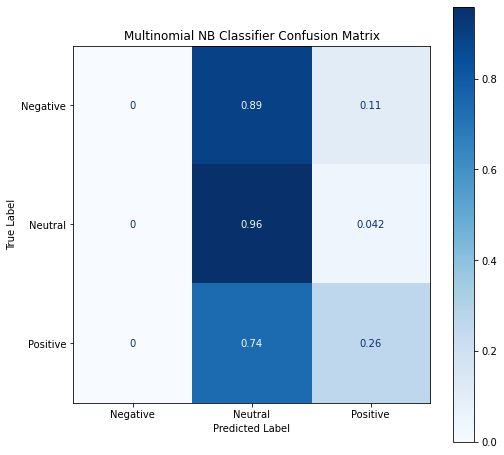

In [373]:
plot_pretty_cf(nb_classifier, tf_idf_data_test, test_sentiment, title='Multinomial NB Classifier Confusion Matrix')

In [374]:
rf_classifier.fit(tf_idf_data_train, train_sentiment)
rf_train_preds = rf_classifier.predict(tf_idf_data_train)
rf_test_preds = rf_classifier.predict(tf_idf_data_test)

In [375]:
rf_train_score = accuracy_score(train_sentiment, rf_train_preds)
rf_test_score = accuracy_score(test_sentiment, rf_test_preds)

print('Random Forest')
print("Training Accuracy: {:.4} \t\t Testing Accuracy: {:.4}".format(rf_train_score, rf_test_score))

Random Forest
Training Accuracy: 0.9657 		 Testing Accuracy: 0.6954


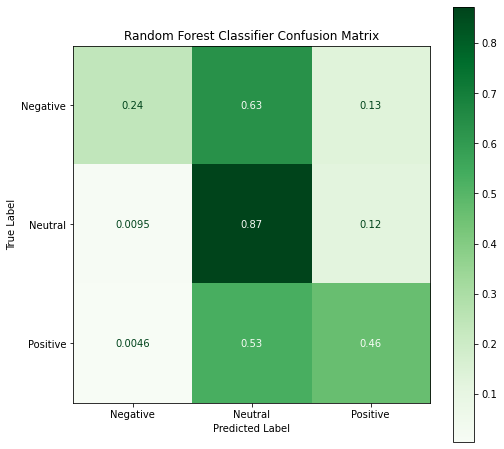

In [376]:
plot_pretty_cf(rf_classifier, tf_idf_data_test, test_sentiment, cmap='Greens', title='Random Forest Classifier Confusion Matrix')

In [377]:
print(classification_report(test_sentiment, rf_test_preds, target_names=['Negative', 'Neutral', 'Positive']))

              precision    recall  f1-score   support

    Negative       0.68      0.24      0.35       169
     Neutral       0.71      0.87      0.78      1573
    Positive       0.66      0.46      0.54       868

    accuracy                           0.70      2610
   macro avg       0.68      0.52      0.56      2610
weighted avg       0.69      0.70      0.67      2610



### Random Forest is the better model choice. Now let's see if we can improve our performance. There is MASSIVE overfitting.

In [361]:
svc_clf = Pipeline([('tfidf_vec', TfidfVectorizer(analyzer='word', tokenizer=tokenize_tweet, strip_accents='unicode', decode_error='ignore')), 
                    ('clf', LinearSVC())])

svc_clf.fit(train_tweets, train_sentiment)

Pipeline(steps=[('tfidf_vec',
                 TfidfVectorizer(decode_error='ignore', strip_accents='unicode',
                                 tokenizer=<function tokenize_tweet at 0x7f4e786bca60>)),
                ('clf', LinearSVC())])

In [362]:
svc_train_predictions = svc_clf.predict(train_tweets)
svc_test_predictions = svc_clf.predict(test_tweets)

In [363]:
svc_train_score = accuracy_score(train_sentiment, svc_train_predictions)
svc_test_score = accuracy_score(test_sentiment, svc_test_predictions)
print("SVC")
print("Training Accuracy: {:.4} \t\t Testing Accuracy: {:.4}".format(svc_train_score, svc_test_score))

SVC
Training Accuracy: 0.9274 		 Testing Accuracy: 0.6939


In [364]:
print(classification_report(test_sentiment, svc_test_predictions, target_names=['Negative', 'Neutral', 'Positive']))

              precision    recall  f1-score   support

    Negative       0.57      0.25      0.35       169
     Neutral       0.74      0.81      0.77      1573
    Positive       0.61      0.57      0.59       868

    accuracy                           0.69      2610
   macro avg       0.64      0.54      0.57      2610
weighted avg       0.69      0.69      0.68      2610



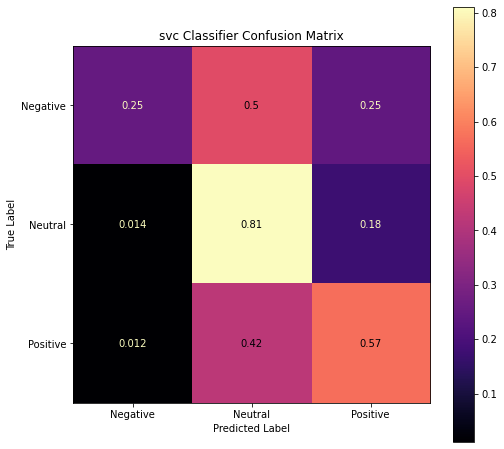

In [365]:
plot_pretty_cf(svc_clf, test_tweets, test_sentiment, cmap='magma', title='svc Classifier Confusion Matrix')